In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("C:/Archives/Internship/Data/Misc/covid19_all_countries.csv", usecols = [0,4,5,6,9], engine = 'python')
df = df.rename(columns = {'dateRep':'date', 'countriesAndTerritories':'country','popData2018': 'pop'}) # rename columns
df.date = pd.to_datetime(df.date, infer_datetime_format=True) # datetime
df.head()

,date,cases,deaths,country,pop
0,2020-03-27,0,0,Afghanistan,37172386.0
1,2020-03-26,33,0,Afghanistan,37172386.0
2,2020-03-25,2,0,Afghanistan,37172386.0
3,2020-03-24,6,1,Afghanistan,37172386.0
4,2020-03-23,10,0,Afghanistan,37172386.0


In [4]:
# Country population dictionary
country_pop = (df.groupby('country').pop.mean())
country_pop = country_pop.to_dict()

In [5]:
# Country level COVID-19
def ts(country, alpha):
    c = df[df.country == country][['date','cases','deaths']].set_index('date')
    c['cases_expsm'] = c.cases.ewm(alpha = alpha).mean()
    return c

C:\Users\40102484\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


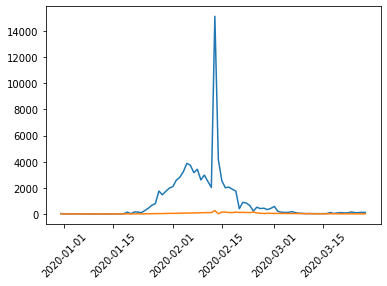

In [6]:
# Country-Plot
df_country = ts('China', alpha = 0.3)
plt.plot(df_country.index, df_country.cases)
plt.plot(df_country.index, df_country.deaths)
plt.xticks(rotation = 45)
plt.show()

#### Suspected Infected Recovered (SIR) Model

Modelling assumptions listed here: 
https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model

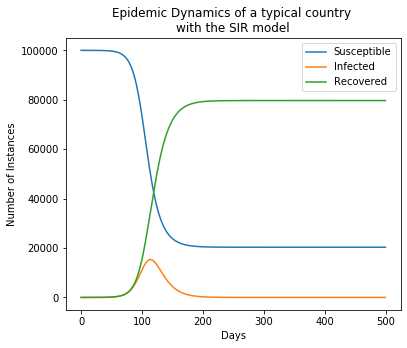

In [7]:
from scipy.integrate import odeint

# state space function

def model(z, t, b, k, N):
    S = z[0]
    I = z[1]
    R = z[2]
    dSdt = -b*S*I/N
    dIdt = b*S*I/N - k*I
    dRdt = k*I
    dzdt = (dSdt, dIdt, dRdt)
    return dzdt

# initial conditions
total_pop = 100000
infected = 1
recovered = 1
z0 = [total_pop - infected, infected, recovered]

# time points
n = 500
t = np.linspace(0,n-1,n)

# solution matrices
S = np.empty_like(t)
I = np.empty_like(t)
R = np.empty_like(t)

S[0],I[0],R[0] = z0[0], z0[1], z0[2]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]] 
    # solve for next step
    z = odeint(model, z0, tspan, args = (0.2, 0.1, total_pop-infected))
    # populate solution matrices
    S[i] = z[1][0]
    I[i] = z[1][1]
    R[i] = z[1][2]
    # next initial condition
    z0 = z[1]
    
# plot resuts
plt.figure(figsize = (6,5))
plt.plot(t,S, label = 'Susceptible')
plt.plot(t,I, label = 'Infected')
plt.plot(t,R, label = 'Recovered')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of Instances')
plt.title('Epidemic Dynamics of a typical country \nwith the SIR model')
plt.show()

#### Suspected Infected Suspected (SIS) Model

Model assumptions and details found here:
https://mysite.science.uottawa.ca/rsmith43/MAT4996/Epidemic.pdf

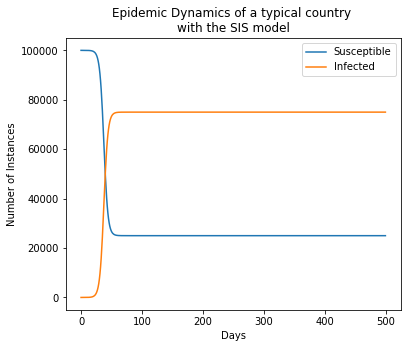

In [8]:
from scipy.integrate import odeint

# state space function

def model(z, t, a, b, N):
    S = z[0]
    I = z[1]
    dSdt = b*I - a*S*I/N
    dIdt = a*S*I/N - b*I
    dzdt = (dSdt, dIdt)
    return dzdt

# initial conditions
total_pop = 100000
infected = 1
recovered = 1
z0 = [total_pop - infected, infected]

# time points
n = 500
t = np.linspace(0,n-1,n)

# solution matrices
S = np.empty_like(t)
I = np.empty_like(t)

S[0],I[0] = z0[0], z0[1]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]] 
    # solve for next step
    z = odeint(model, z0, tspan, args = (0.4, 0.1, total_pop-infected))
    # populate solution matrices
    S[i] = z[1][0]
    I[i] = z[1][1]
    # next initial condition
    z0 = z[1]
    
# plot resuts
plt.figure(figsize = (6,5))
plt.plot(t,S, label = 'Susceptible')
plt.plot(t,I, label = 'Infected')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of Instances')
plt.title('Epidemic Dynamics of a typical country \nwith the SIS model')
plt.show()

#### SIR Model with Age Groups, Asymptomatic Behaviour and Contact Dynamics

Let us assume we have $M = 2$ age groups


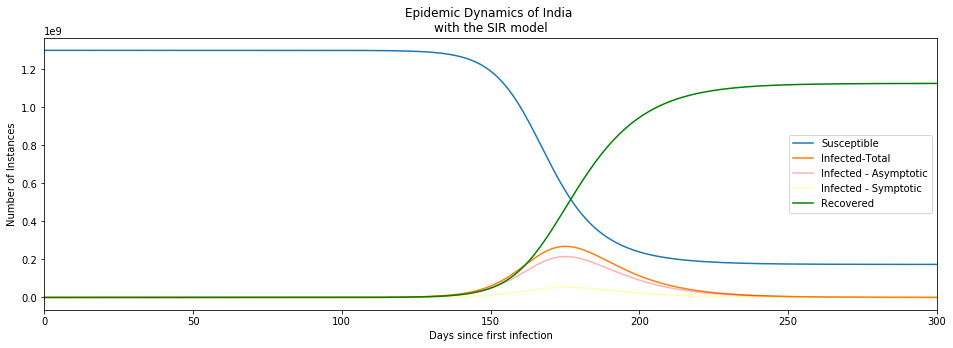

In [217]:
# parameters
self_isolation_factor = 0.4 

# time points
n = 500
t = np.linspace(0, n-1, n)

# contact matrix
C = np.zeros(shape = (2,2))
C[:,:] = [[15,20],[20,70]] # initial assignment

# symptomatic contact matrix
Cs = C*self_isolation_factor

# state space function
def model1(z,t,alpha,beta,gamma,self_isolation_factor,Ni):
    S, Ia, Is, R = z[0], z[1], z[2], z[3] # variable declaration
    
    # contact matrix
    C = np.zeros(shape = (2,2))
    C[:,:] = [[15,0.2],[0.2,71]] # initial assignment
    
#     # quarantine effects
#     if ((t>60) & (t<81)): # from t = 60 to t = 81
#         f1 = -1/(1+ np.exp(-t+60)) + 1 # shifted sigmoid decaying contact diminishing
#         C[:,:] = f1*C[:,:] # factor by which contact diminished
        
#     if ((t>92) & (t<108)): # from t = 92 to t = 108
#         C[:,:] = 0*C[:,:] # factor by which contact diminished

    Cs = C*f # symp contact matrix
    lambda_i = beta*(np.sum(C[0,:])*Ia/Ni + np.sum(Cs[0,:])*Is/Ni) # lambda
    dSdt = -lambda_i*S
    dIadt = alpha*lambda_i*S - gamma*Ia
    dIsdt = (1-alpha)*lambda_i*S - gamma*Is
    dRdt = gamma*(Ia + Is)
    dzdt = (dSdt, dIadt, dIsdt, dRdt)
    return dzdt

# initial conditions
total_pop = 1300000000
infected_a = 0
infected_s = 1
recovered = 0
z0 = [total_pop, infected_a, infected_s, recovered]

# solution matrices
S = np.empty_like(t)
Ia = np.empty_like(t)
Is = np.empty_like(t)
R = np.empty_like(t)

# initialization
S[0], Ia[0], Is[0], R[0] = z0[0], z0[1], z0[2], z0[3]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]]
    # solve for next step
    z = odeint(model1, z0, tspan, args = (0.8,0.0165,0.095,0.6,total_pop))
    # populate solution matrices
    S[i] = z[1][0]
    Ia[i] = z[1][1]
    Is[i] = z[1][2]
    R[i] = z[1][3]
    # next initial condition
    z0 = z[1]
    
# plot results
plt.figure(figsize = (16,5))
plt.plot(t,S, label = 'Susceptible')
plt.plot(t,np.array(Ia) + np.array(Is), label = 'Infected-Total')
plt.plot(t,Ia, label = 'Infected - Asymptotic', alpha = 0.3, c = 'red')
plt.plot(t,Is, label = 'Infected - Symptotic', alpha = 0.3, c = 'yellow')
plt.plot(t,R, label = 'Recovered', c = 'green')
plt.legend()
plt.xlabel('Days since first infection')
plt.ylabel('Number of Instances')
plt.title('Epidemic Dynamics of India \nwith the SIR model')
plt.xlim([0,300])
# plt.ylim([0,3000])
plt.show()

#### Suspected Latent Infected Recovered Dead Suspected (SLIRDS) Model

Model assumptions and details found here: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6926909/

In [196]:
from scipy.integrate import odeint

# state space function

def model(z, t, a, b, N):
    S = z[0]
    L = z[1]
    I = z[2]
    R = z[3]
    D = z[4]
    dSdt = d*R - b*S*I/N
    
    dIdt = w*L + a*S*I/N - b*I
    
    dzdt = (dSdt, dIdt)
    return dzdt

# initial conditions
total_pop = 100000
infected = 1
recovered = 1
z0 = [total_pop - infected, infected]

# time points
n = 500
t = np.linspace(0,n-1,n)

# solution matrices
S = np.empty_like(t)
I = np.empty_like(t)

S[0],I[0] = z0[0], z0[1]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]] 
    # solve for next step
    z = odeint(model, z0, tspan, args = (0.4, 0.1, total_pop-infected))
    # populate solution matrices
    S[i] = z[1][0]
    I[i] = z[1][1]
    # next initial condition
    z0 = z[1]
    
# plot resuts
plt.figure(figsize = (6,5))
plt.plot(t,S, label = 'Susceptible')
plt.plot(t,I, label = 'Infected')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of Instances')
plt.title('Epidemic Dynamics of a typical country \nwith the SIS model')
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

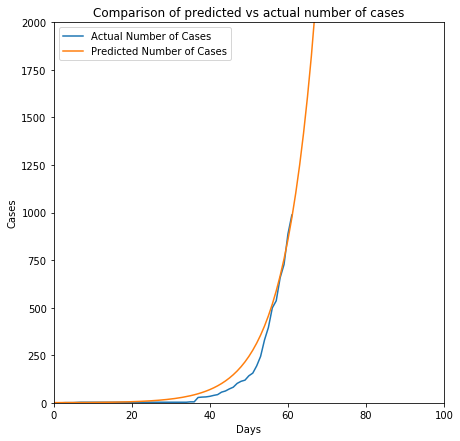

In [224]:
df1 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

country_ts = df1[df1['Country/Region'] == 'India'].T[4:].reset_index()
country_ts = country_ts.rename(columns = {'index':'date', 131:'cases'})
country_ts.date = pd.to_datetime(country_ts.date, infer_datetime_format=True)
country_ts = country_ts.set_index('date')

plt.figure(figsize = (7,7))
plt.plot(country_ts.values[5:], label = 'Actual Number of Cases')
plt.plot(t,np.array(Ia) + np.array(Is), label = 'Predicted Number of Cases')
plt.xlim([0,100])
plt.ylim([0,2000])
plt.title('Comparison of predicted vs actual number of cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()